Please note that this notebook was originally ran on kaggle and downloaded afterward, so the current paths are not correct for re-running.<br>
To run it, please change the paths to the correct ones.<br>
<br>

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import copy

plt.ion()   # interactive mode

In [3]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
setup_seed(20)

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'eval': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/kaggle/input/caltech101/Caltech101'
batch_size = 64
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'eval', 'test']}
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'eval', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size//8, shuffle=True, num_workers=4) for x in ['eval', 'test']}
dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'eval', 'test']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(class_names)

cuda:0
['Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 'soccer_ball', '

In [5]:
class ModifiedNet1(nn.Module):

    def __init__(self):
        super(ModifiedNet1, self).__init__()
        
        self.conv64_x_2 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.max_pool_1 = nn.MaxPool2d(2)
        
        self.conv128_x_2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.max_pool_2 = nn.MaxPool2d(2)
        
        self.conv256_x_3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.max_pool_3 = nn.MaxPool2d(2)
        
        self.conv512_x_3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.max_pool_4 = nn.MaxPool2d(2)
        
        self.ave_pool = nn.AdaptiveAvgPool2d(output_size=(7, 7))
        
        self.FC = nn.Sequential(
            nn.Linear(in_features=25088, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=1024, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(in_features=1024, out_features=101, bias=True) 
        )
        
    def forward(self, x):
        x = self.conv64_x_2(x)
        x = self.max_pool_1(x)
        x = self.conv128_x_2(x)
        x = self.max_pool_2(x)
        x = self.conv256_x_3(x)
        x = self.max_pool_3(x)
        x = self.conv512_x_3(x)
        x = self.max_pool_4(x)
        x = self.ave_pool(x)
        x = x.view(-1, 25088)
        x = self.FC(x)

        return x

In [6]:
# def train_model(model, criterion, optimizer, scheduler, num_epochs):
def train_model(model, criterion, optimizer, num_epochs):
    since = time.time()
    
    statistics = {'train':([],[]), 'eval':([],[])} # train:(loss,acc), test:(loss,acc)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
#     early_stopping = EarlyStopping(patience=7, verbose=True)
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'eval']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            step_loss = []
            step_acc = []
                      
            for step,(inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward，track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                step_loss.append(loss.item())
                step_acc.append(float(torch.sum(preds == labels.data)) / preds.size(0))                     
                
                # statistics                
                if step%10==1:
                    statistics[phase][0].append(np.mean(step_loss))
                    statistics[phase][1].append(np.mean(step_acc))
                    step_loss = []
                    step_acc = []
                    
#             if phase == 'train':
#                 scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
#             statistics[phase][0].append(epoch_loss)
#             statistics[phase][1].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'eval' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
#         early_stopping(epoch_loss, model)
#         if early_stopping.early_stop:
#             print("Early stopping")
#             break
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best eval Acc: {:4f}'.format(best_acc))

#     model.load_state_dict(torch.load('checkpoint.pt'))
    return model, statistics

## continue training model1_3 --> model1_4

In [7]:
model1_4 = torch.load('/kaggle/input/model1/whole model1_3.pth')
model1_4 = model1_4.to(device)

criterion4 = nn.CrossEntropyLoss()
optimizer4 = optim.Adam(model1_4.parameters(),lr=0.001,weight_decay=1e-5)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer1, step_size=7, gamma=0.1) # Decay LR by a factor of 0.1 every 7 epochs

In [8]:
model1_4, statistics = train_model(model1_4, criterion4, optimizer4, num_epochs=50)

Epoch 0/49
----------
train Loss: 1.4972 Acc: 0.6349
eval Loss: 1.1202 Acc: 0.6963

Epoch 1/49
----------
train Loss: 1.4058 Acc: 0.6472
eval Loss: 1.0528 Acc: 0.7110

Epoch 2/49
----------
train Loss: 1.3382 Acc: 0.6595
eval Loss: 1.0727 Acc: 0.6976

Epoch 3/49
----------
train Loss: 1.2967 Acc: 0.6665
eval Loss: 1.0364 Acc: 0.7024

Epoch 4/49
----------
train Loss: 1.2888 Acc: 0.6672
eval Loss: 1.0839 Acc: 0.7061

Epoch 5/49
----------
train Loss: 1.2993 Acc: 0.6675
eval Loss: 1.0951 Acc: 0.7085

Epoch 6/49
----------
train Loss: 1.2962 Acc: 0.6689
eval Loss: 1.0525 Acc: 0.7244

Epoch 7/49
----------
train Loss: 1.2667 Acc: 0.6779
eval Loss: 1.0483 Acc: 0.7183

Epoch 8/49
----------
train Loss: 1.2781 Acc: 0.6689
eval Loss: 1.0634 Acc: 0.7183

Epoch 9/49
----------
train Loss: 1.2328 Acc: 0.6801
eval Loss: 1.0835 Acc: 0.7195

Epoch 10/49
----------
train Loss: 1.2475 Acc: 0.6818
eval Loss: 1.1035 Acc: 0.7195

Epoch 11/49
----------
train Loss: 1.2480 Acc: 0.6720
eval Loss: 1.0620 Acc

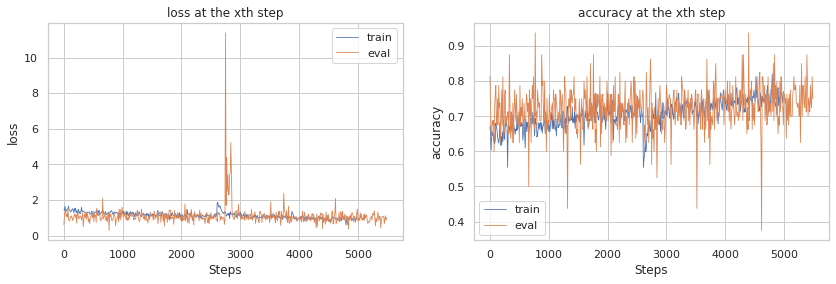

In [9]:
num_epochs=50
def visualize_accuracy(num_epochs, statistics):
    sns.set(style="whitegrid")
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
    for phase,(loss,acc) in statistics.items():
        loss_hist = [float(h) for h in loss]
        acc_hist = [float(h) for h in acc]
        ax1.plot(np.arange(len(loss_hist))*10, loss_hist, label = phase, linewidth = 0.8)
#         ax1.set(xlabel = 'Epochs', ylabel='loss',title='loss at the xth epoch');
        ax1.set(xlabel = 'Steps', ylabel='loss',title='loss at the xth step');
        ax1.legend();
        ax2.plot(np.arange(len(acc_hist))*10, acc_hist, label = phase, linewidth = 0.8)
#         ax2.set(xlabel = 'Epochs', ylabel='accuracy',title='accuracy at the xth epoch');
        ax2.set(xlabel = 'Steps', ylabel='accuracy',title='accuracy at the xth step');
        ax2.legend();
        fig.savefig('acc_loss_model1_4.png')
visualize_accuracy(num_epochs, statistics)

In [10]:
PATH = '/kaggle/working/model1_4.pth'
torch.save(model1_4.state_dict(), PATH)
PATH = '/kaggle/working/whole model1_4.pth'
torch.save(model1_4, PATH)

/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ModifiedNet1. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
